In [7]:
## Import packages

import sys
import os
import numpy as np
#import h5py
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import seaborn as sns
import networkx as nx


In [8]:
## Double check we are in the correct location.

# Get working directory
print(os.getcwd())

# List files in our directory
print(os.listdir())

# Can't remember what these functions do?
#np.mean?

/home/jovyan/lecture_5_02_04_2020
['.DS_Store', 'Lecture5_02_04_2020_final.ipynb', '.ipynb_checkpoints', 'data']


## Brain data
Inside the data folder, we have structural connectivity data for the brains of 8 individuals (each scanned in triplicate). Before looking at all the data, let's read in _one_ brain and get some intuition.

Data were originally stored as .mat files. We'll need the scipy module to read the matrices into numpy arrays.

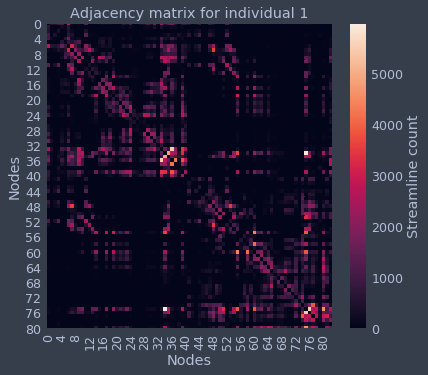

In [9]:
# Load in one brain
example_number = 1    # Pick any number from 0-23

# Load in one scan as brain_example. 
brain_example = sio.loadmat(f'data/brain_{example_number}.mat')

# The brain_example has the adjacency matrix stored as 'adj'
brain_example = brain_example['adj']
# Symmetrize and set diagonal to 0
brain_example = 0.5*(brain_example + np.transpose(brain_example))
np.fill_diagonal(brain_example,0)

# From this brain, we can find the number of nodes, call it n_nodes
brain_example.shape
n_nodes = brain_example.shape[0]

# Look at the adjacency matrix

# With seaborn
fig_0 = sns.heatmap(brain_example, cbar_kws={'label': 'Streamline count'})
fig_0.set(xlabel = 'Nodes', ylabel = 'Nodes', title = f'Adjacency matrix for individual {example_number}');


# # With matplotlib
# plt.pcolor(brain_example)
# plt.title('pcolor')
# plt.xlabel('Nodes')
# plt.ylabel('Nodes')
# plt.title(f'Adjacency matrix for individual {example_number}')
# plt.colorbar(label = 'Streamline count')

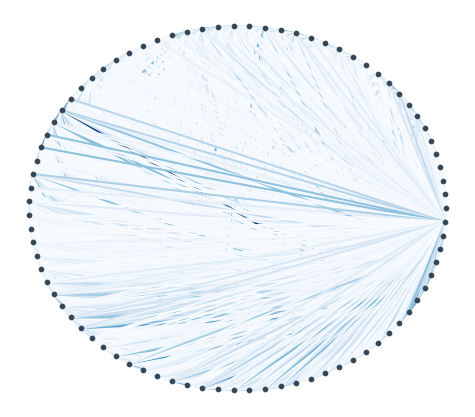

In [10]:
# What does the network itself actually look like?
# Create a weighted graph using networkx

G_example = nx.from_numpy_array(brain_example, parallel_edges = False)
pos = nx.circular_layout(G_example)
colors = [d['weight'] for u,v,d in G_example.edges(data = True)]

# for u,v,d in G_example.edges(data=True):
#     print(d['weight'])

nx.draw(G_example, pos, node_color='#344555', edge_color=colors, node_size = 30,
        width=2, edge_cmap=plt.cm.Blues, with_labels=False)
plt.show()

In [11]:
# Yikes that was not so helpful. Let's read in the coordinates of the actual brain data.

# data_array = {}
# with h5py.File('data/coordinatesXYZ.mat', 'r') as f:
# #     for k, v in f.items():
# #         data_array[k] = np.array(v)
#     data_array = {k: np.array(v) for k,v in f.items()}
# x_coord = data_array['X'][0]
# y_coord = data_array['Y'][0]
# z_coord = data_array['Z'][0]

coordinates_mat = sio.loadmat('data/LP_coordinates.mat')
x_coord = coordinates_mat['X']
y_coord = coordinates_mat['Y']
z_coord = coordinates_mat['Z']


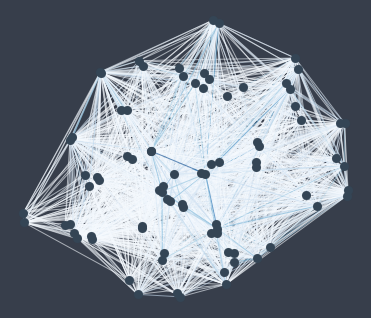

In [12]:
# Now we can plot!

# Need to assign node locations
for node in G_example.nodes():
    G_example.nodes[node]['pos'] = [y_coord[node][0], z_coord[node][0]]
    

pos = nx.get_node_attributes(G_example,'pos')
nx.draw_networkx_edges(G_example,pos,alpha=0.6,edge_color=colors,edge_cmap=plt.cm.Blues)
# Play with different colormaps (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html). Which is the most helpful?
nx.draw_networkx_nodes(G_example,pos, node_size = 80, node_color = '#344555')
plt.axis('off')
plt.show()

## Learning about the brain

Now that we have an idea of what the brain looks like, let's learn some more qunatitative information about it. We'll start with some questions about connectivity.

The mean edge weight is 273.46320220641604.
The median edge weight is 8.0.


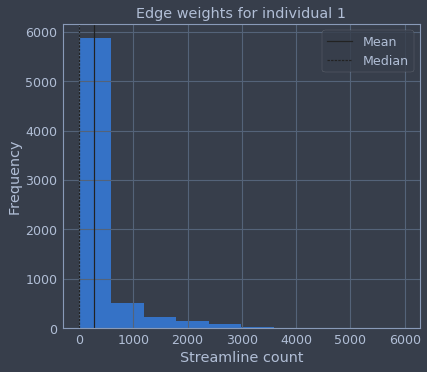

In [13]:
# What does the distribution of edge weights look like?

edge_weights = brain_example.flatten()

# What is the average edge weight?
mean_edge_weight = edge_weights.mean()
print(f'The mean edge weight is {mean_edge_weight}.')

median_edge_weight = np.median(edge_weights)
print(f'The median edge weight is {median_edge_weight}.')


# With seaborn
# fig_1 = sns.distplot(edge_weights, kde = False)
# fig_1.set(xlabel = 'Streamline count', ylabel = 'Frequency', title = f'Edge weights for individual {example_number}');
# fig_1.axvline(mean_edge_weight, label = 'Mean')
# fig_1.axvline(median_edge_weight, label = 'Median', dashes = (2,1,2,1))
# fig_1.legend();


# With matplotlib
plt.hist(edge_weights)
plt.axvline(mean_edge_weight, label = 'Mean', color = 'k')
plt.axvline(median_edge_weight, label = 'Median', dashes = (2,1,2,1), color = 'k')
plt.xlabel('Streamline count')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Edge weights for individual {example_number}');


The mean edge weight is 432.87867647058823.
The median edge weight is 109.0.


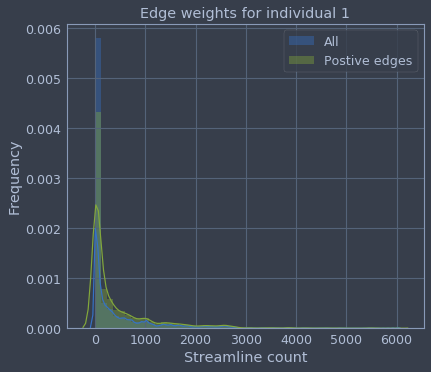

In [14]:
# Hmm are there a bunch of low weight edges or just a lot of zeros? Zeros mean no edge exists so we should not include them.
edge_weights_pos = edge_weights[edge_weights > 0].copy()

mean_edge_weight_pos = edge_weights_pos.mean()
print(f'The mean edge weight is {mean_edge_weight_pos}.')

median_edge_weight_pos = np.median(edge_weights_pos)
print(f'The median edge weight is {median_edge_weight_pos}.')


fig_2 = sns.distplot(edge_weights, kde = True, label = 'All')
sns.distplot(edge_weights_pos, kde = True, label = 'Postive edges')
fig_2.legend()
fig_2.set(xlabel = 'Streamline count', ylabel = 'Frequency', title = f'Edge weights for individual {example_number}');


# plt.hist(edge_weights, label = 'All', density = True)
# plt.hist(edge_weights_pos, label = 'Positive edges', density = True)
# plt.xlabel('Streamline count')
# plt.ylabel('Frequency')
# plt.title(f'Edge weights for individual {example_number}')
# plt.legend()
# plt.show()

## Sampling and error

Let's practice sampling on the brain data. We'll keep just our one individual for now and sample from the edges of the data to estimate the mean edge weight. 

There are a few ways we might randomly sample edges. We have made it extra easy on ourselves by already creating an array called `edge_weights_pos`. How could we sample straight from the matrix?

In [9]:
# How many edges do we have?
print(len(edge_weights_pos))

# Are these _all_ the edges?
print(len(np.unique(edge_weights_pos)))

# What is going on?

4352
864


In [10]:
# Sort and remove duplicates
sorted_edge_weights_pos = np.sort(edge_weights_pos)
#sum(edge_weights_pos==7)

# Slice notation a[start_index:end_index:step]
edge_weights_unique = sorted_edge_weights_pos[::2]
print(len(edge_weights_unique))

2176


In [11]:
# Now we can finally sample!

n = 10
sample_1 = np.random.choice(edge_weights_unique, n, replace = False)
print(sample_1.mean())

96.4


In [12]:
## Sample many times and plot the distribution of means

n_replicates = 100
sample_mean_vec = np.zeros((n_replicates, 1))

for rep in range(n_replicates):
    
    # Sample randomly n points from the population
    sample_i = np.random.choice(edge_weights_unique, n, replace = False)
    
    # Compute the mean of the sample
    sample_i_mean = np.mean(sample_i)
    
    # Store the mean
    sample_mean_vec[rep, 0] = sample_i_mean

print("done with experiment")

done with experiment


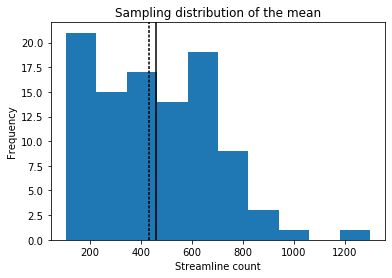

In [13]:
# Plot our sampling distribution!

plt.hist(sample_mean_vec, label = 'Sample means')
plt.axvline(sample_mean_vec.mean(), label = 'Mean of sample means', color = 'k')
plt.axvline(edge_weights_unique.mean(), label = 'True mean', dashes = (2,1,2,1), color = 'k')
plt.xlabel('Streamline count')
plt.ylabel('Frequency')
plt.title('Sampling distribution of the mean')
plt.show()

# fig_3 = sns.distplot(sample_mean_vec, label = 'Sample means', kde = False)
# fig_3.axvline(sample_mean_vec.mean(), label = 'Mean of sample means')
# fig_3.axvline(edge_weights_unique.mean(), label = 'True mean', dashes = (2,1,2,1))
# fig_3.legend()
# fig_3.set(xlabel = 'Streamline count', ylabel = 'Frequency', title = 'Sampling distribution of the mean');



In [14]:
# What is the uncertainty in our estimate?
n = 30

sample_1 = np.random.choice(edge_weights_unique, n, replace = False)
print(f'The sample mean is {sample_1.mean()}')
print(f'The true mean is {edge_weights_unique.mean()}')

# We learned about the standard deviation eariler.
sample_1_stdev = np.std(sample_1, ddof = 1)
print(f'The standard deviaiton of our sample is {sample_1_stdev}')

sample_1_sem_calc = sample_1_stdev/np.sqrt(n)
print(f'The standard error of the mean via calculation is {sample_1_sem_calc}')


sample_1_sem_fn = stats.sem(sample_1, ddof = 1)   # Default is ddof = 1!!!
print(f'The standard error of the mean via stats.sem is {sample_1_sem_fn}')



The sample mean is 512.0666666666667
The true mean is 432.87867647058823
The standard deviaiton of our sample is 687.6435490679111
The standard error of the mean via calculation is 125.54596111580182
The standard error of the mean via stats.sem is 125.54596111580182


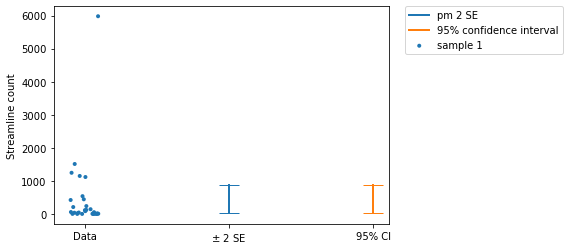

In [15]:
# Let's make some plots that show our estimates


sample_1 = np.random.choice(edge_weights_unique, n, replace = False)
sample_2 = np.random.choice(edge_weights_unique, n, replace = False)

sample_1_sem = stats.sem(sample_1, ddof = 1)
sample_2_sem = stats.sem(sample_2, ddof = 1)

# Estimate 95% confidence intervals
sample_1_ci_left = np.mean(sample_1) - 2*sample_1_sem
sample_1_ci_right = np.mean(sample_1) + 2*sample_1_sem
sample_2_ci_left = np.mean(sample_2) - 2*sample_2_sem
sample_2_ci_right = np.mean(sample_2) + 2*sample_2_sem


fig_4 = sns.stripplot(sample_1, jitter = 0.05, size = 4, orient = 'v', label = 'sample 1')
plt.plot([0.5, 0.5], [sample_1.mean() - 2*sample_1_sem, sample_1.mean() + 2*sample_1_sem], label = 'pm 2 SE',
         lw = 2, marker = '_', markersize = 20)
plt.plot([1, 1], [sample_1_ci_left, sample_1_ci_right], label = '95% confidence interval', 
         lw = 2, marker = '_', markersize = 20)

lgd = plt.legend(loc=2, bbox_to_anchor=(1.05,1), borderaxespad = 0.0)
plt.ylabel('Streamline count')
plt.xticks(np.arange(3)/2, ('Data', r'$\pm$ 2 SE','95% CI'));



## Using all the brain data

We got a feeling for one brain, but what can we learn about the variability across scans? Let's load in all of the brain data and store as `brain_array` to find out.


In [16]:
# Load in all the brain data using a for loop.
print(os.listdir('./data'))


n_individuals = 24
brain_array = np.zeros((n_nodes, n_nodes, n_individuals))

for i in range(24):
    brain_i_data = sio.loadmat(f'data/brain_{i}.mat')
    brain_i = brain_i_data['adj']
    brain_array[:, :, i] = brain_i
    
print('\n done loading brains :)')

['LP_coordinates.mat', 'brain_23.mat', 'brain_0.mat', 'brain_1.mat', 'brain_22.mat', 'brain_20.mat', 'brain_3.mat', 'brain_2.mat', 'brain_21.mat', 'brain_19.mat', 'brain_6.mat', 'brain_7.mat', 'brain_18.mat', 'brain_5.mat', 'brain_4.mat', 'brain_16.mat', 'brain_9.mat', 'brain_8.mat', 'brain_17.mat', 'brain_15.mat', 'brain_14.mat', 'brain_10.mat', 'brain_11.mat', 'brain_13.mat', 'coordinatesXYZ.mat', 'brain_12.mat']

 done loading brains :)


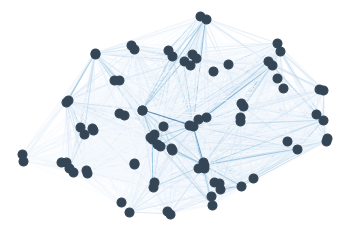

In [17]:
# Graph a brain to make sure we loaded everything correctly

check_number = 9
G_check = nx.from_numpy_array(brain_array[:, :, check_number], parallel_edges = False)

colors = [d['weight'] for u,v,d in G_example.edges(data = True)]

# Need to assign node locations
for node in G_check.nodes():
    G_check.nodes[node]['pos'] = [y_coord[node][0], z_coord[node][0]]
    

pos=nx.get_node_attributes(G_example,'pos')
nx.draw_networkx_edges(G_example,pos,alpha=0.6,edge_color=colors,edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G_example,pos, node_size = 80, node_color = '#344555')
plt.axis('off')
plt.show()

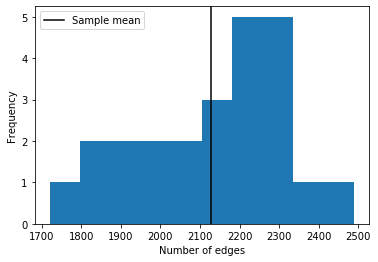

In [18]:
# How many edges are in each brain?

n_edges_vec = np.zeros((n_individuals,1))
for i in range(n_individuals):
    G_i = nx.from_numpy_array(brain_array[:, :, i], parallel_edges = False)
    n_edges = len(G_i.edges())
    n_edges_vec[i, 0] = n_edges
    
# print(n_edges_vec)

# Draw a histogram of our reported edge number
# fig_5 = sns.distplot(n_edges_vec, kde = False)
# fig_5.axvline(n_edges_vec.mean(), label = 'Sample mean')
# fig_5.legend()
# fig_5.set(xlabel = 'Number of edges', ylabel = 'Frequency');

plt.hist(n_edges_vec)
plt.axvline(n_edges_vec.mean(), label = 'Sample mean', color = 'k')
plt.xlabel('Number of edges')
plt.ylabel('Frequency')
plt.legend();

In [19]:
# How well can we estimate the mean number of edges for the population of all adults?

n_edges_sem = stats.sem(n_edges_vec, ddof = 1)

print(n_edges_sem)

[39.63191051]


In [20]:
# How does the number of edges vary with the maximum edge weight across individuals?


# For each individual (0:7) let's calculate the mean and SE for the number of edges and maximum edge weight.

def raw_brain_matrix_to_edge_array(brain_mat):
    
    brain_mat = 0.5*(brain_mat + np.transpose(brain_mat))
    np.fill_diagonal(brain_mat,0)
    brain_mat_triu = np.triu(brain_mat)
    edge_weights = brain_mat_triu.flatten()
    edge_weights_pos = edge_weights[edge_weights > 0].copy()
    
    return edge_weights_pos

# edge_weights_pos_test = raw_brain_matrix_to_edge_array(brain_array[:, :, 1])
# print(edge_weights_pos_test.mean())
# print(np.median(edge_weights_pos))



n_scans = 3
n_individuals = 8


# Calculate number of edges and highest edge weight 
n_edges_individual_array = np.zeros((n_individuals, 1))
n_edges_individual_sem = np.zeros((n_individuals, 1))
max_edge_individual_array = np.zeros((n_individuals, 1))
max_edge_individual_sem = np.zeros((n_individuals, 1))

# Could have made n_individuals a list -- for person in people: ...
for person in range(n_individuals):
    
    # Need to store outputs for each indivudal
    individual_edge_numbers = np.zeros((n_scans, 1))
    individual_max_edge = np.zeros((n_scans, 1))
    
    for scan in range(n_scans):
        #print(person, scan)
        
        edge_weights_individual_scan = raw_brain_matrix_to_edge_array(brain_array[:, :, person*n_scans + scan])
        individual_edge_numbers[scan, 0] = len(edge_weights_individual_scan)
        individual_max_edge[scan, 0] = max(edge_weights_individual_scan)
        
    
    n_edges_individual_array[person, 0] = individual_edge_numbers.mean()
    n_edges_individual_sem[person, 0] = stats.sem(individual_edge_numbers)
    max_edge_individual_array[person, 0] = individual_max_edge.mean()
    max_edge_individual_sem[person, 0] = stats.sem(individual_max_edge)
    

    
    
    
print('Done computing')

Done computing


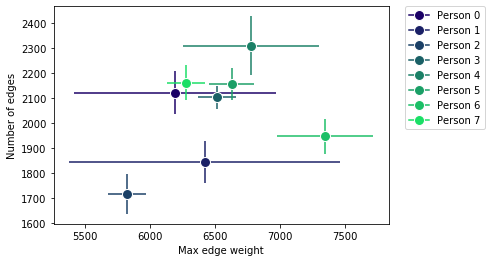

In [84]:
# We finally have everything we need to plot!!

fig = plt.figure()

for person in range(n_individuals):
    person_color = [0.1, (person/n_individuals), 0.4]
    plt.plot(max_edge_individual_array[person, 0],
             n_edges_individual_array[person, 0],
             marker = '.',
             ms = 20,
             color = person_color,
             mec = 'w',
             label = f'Person {person}')
    plt.errorbar(max_edge_individual_array[person, 0], n_edges_individual_array[person, 0],
                 yerr = 2*n_edges_individual_sem[person, 0], color = person_color)
    plt.errorbar(max_edge_individual_array[person, 0], n_edges_individual_array[person, 0],
                 xerr = 2*max_edge_individual_sem[person, 0], color = person_color) #label = r'$\pm$ 2*SE',
    
plt.xlabel('Max edge weight')
plt.ylabel('Number of edges')
plt.legend(loc=2, bbox_to_anchor=(1.05,1), borderaxespad = 0.0);

    

In [ ]:
# from jupyterthemes import jtplot

# # currently installed theme will be used to
# # set plot style if no arguments provided
# jtplot.style(theme='onedork')